# Robustness and Explainability Evaluation


In [18]:
import pandas as pd
import numpy as np
import joblib
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
import sys

# Add the src directory to the Python path to import config
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from config import Config
sys.path.pop(0)

# Load the trained model and feature scaler using paths from config.py
model = None
scaler = None
try:
    model = joblib.load(Config.DEFAULT_MODEL_PATH)
    scaler = joblib.load(Config.FEATURE_SCALER_PATH)
    print("Model and scaler loaded successfully.")
except FileNotFoundError:
    print(f"Error: Ensure model file '{Config.DEFAULT_MODEL_PATH}' and scaler file '{Config.FEATURE_SCALER_PATH}' exist.")
    print("Please train the model using 'src/train_script.py' if you haven't already.")
except Exception as e:
    print(f"An error occurred while loading the model or scaler: {e}")

# Define expected features (excluding 'timestamp', 'label', 'family') based on training data structure
# Assuming training_dataset.csv has the definitive feature set.
training_data_path = Config.BASE_DIR / "src" / "test_data" / "training_dataset.csv"
expected_features = []
try:
    if os.path.exists(training_data_path):
        temp_train_df = pd.read_csv(training_data_path, nrows=1) # Read only header to get columns
        expected_features = [col for col in temp_train_df.columns if col not in ['timestamp', 'label', 'family']]
        print(f"Expected features identified from training data: {expected_features}")
except Exception as e:
    print(f"Error reading training_dataset.csv to get feature names: {e}")
    print("Proceeding without explicit feature name validation from training data, may lead to errors.")

# Load the specific test dataset for ransomware attack scenario
test_data_path = Config.BASE_DIR / "src" / "test_data" / "scenario_ransomware_attack.csv"
X_test = None
y_test = None
X_test_scaled = None

try:
    if os.path.exists(test_data_path):
        test_df = pd.read_csv(test_data_path)
        print(f"Loaded test data from {test_data_path}.")

        if 'label' in test_df.columns:
            y_test = test_df['label']
            # Drop non-feature columns: 'timestamp' and 'family'
            cols_to_drop = [col for col in ['timestamp', 'family', 'label'] if col in test_df.columns]
            X_test_raw = test_df.drop(columns=cols_to_drop, errors='ignore')

            # Ensure X_test contains only numeric features and in the correct order
            if expected_features:
                # Filter and reorder columns based on expected_features
                X_test = X_test_raw[expected_features].copy()
            else:
                X_test = X_test_raw.copy() # Fallback if expected_features couldn't be determined

            # Convert all feature columns to numeric, coercing errors
            for col in X_test.columns:
                X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
            # Fill any NaN values that resulted from coercion (e.g., non-numeric strings)
            X_test = X_test.fillna(0) # Or use a more sophisticated imputation strategy

            if scaler and X_test is not None:
                # Convert X_test to a NumPy array before scaling to avoid 'feature names' warning
                X_test_scaled = scaler.transform(X_test.values) 
                print("Test data scaled successfully.")
            else:
                print("Error: Scaler not loaded or X_test could not be prepared for scaling.")
        else:
            print("Error: 'label' column not found in the test data. Please check the dataset.")
            X_test, y_test, X_test_scaled = None, None, None
    else:
        print(f"Error: Test data file '{test_data_path}' not found. Please ensure it exists.")
        X_test, y_test, X_test_scaled = None, None, None

except Exception as e:
    print(f"An error occurred during test data loading or scaling: {e}")
    X_test, y_test, X_test_scaled = None, None, None



Model and scaler loaded successfully.
Expected features identified from training data: ['file_ops_per_minute', 'unique_extensions_accessed', 'suspicious_extensions', 'process_cpu_mean', 'process_cpu_max', 'process_memory_mean', 'process_memory_max', 'active_processes', 'network_connections', 'file_creation_rate', 'file_deletion_rate', 'file_modification_rate']
Loaded test data from D:\ransomware-detection-system\src\test_data\scenario_ransomware_attack.csv.
Test data scaled successfully.


In [20]:
print("\n--- Robustness Evaluation ---")
if X_test_scaled is not None and y_test is not None and model is not None:
    try:
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability of positive class

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        # Placeholder for more advanced robustness tests
        print("\nConsider adding evaluation against: ")
        print("- Data with different obfuscation techniques")
        print("- Data from unseen ransomware families")
        print("- Adversarial attack simulations")

    except Exception as e:
        print(f"An error occurred during robustness evaluation: {e}")
else:
    print("Cannot perform robustness evaluation: Model, scaled test data, or true labels are not available.")




--- Robustness Evaluation ---
Accuracy: 0.9333
Precision: 1.0000
Recall: 0.9000
F1-Score: 0.9474
ROC AUC: 1.0000

Consider adding evaluation against: 
- Data with different obfuscation techniques
- Data from unseen ransomware families
- Adversarial attack simulations



--- Explainability Evaluation (SHAP) ---

SHAP explanation for the first test instance:



Summary plot of feature importance:


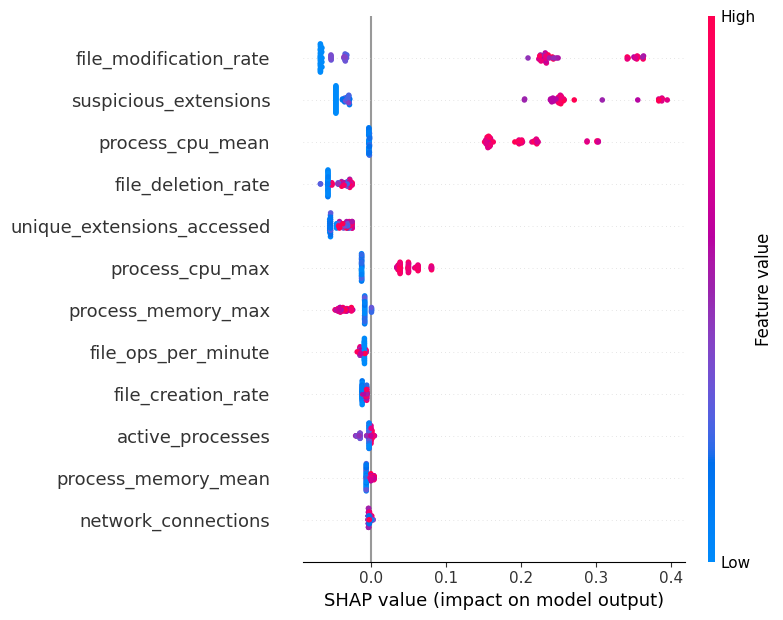


Generating Dependence plots for all features...
Plotting dependence for feature: file_ops_per_minute


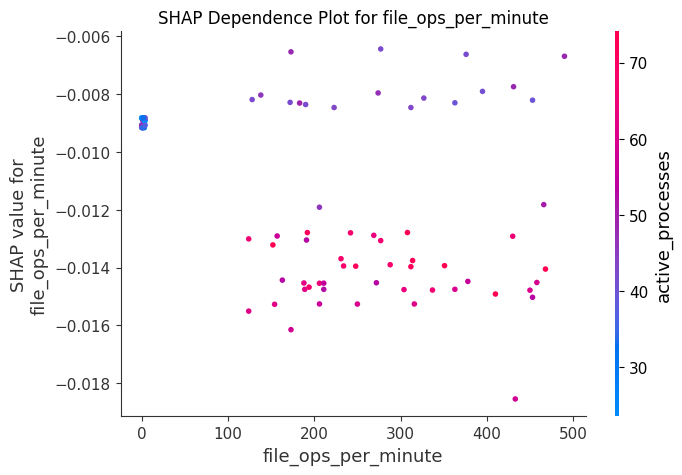

Plotting dependence for feature: unique_extensions_accessed


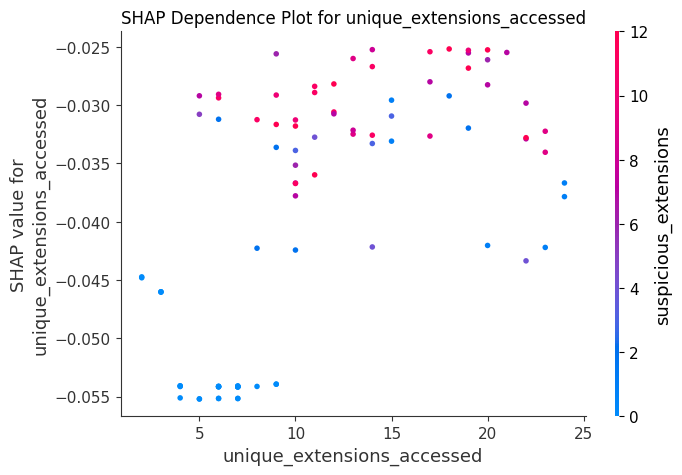

Plotting dependence for feature: suspicious_extensions


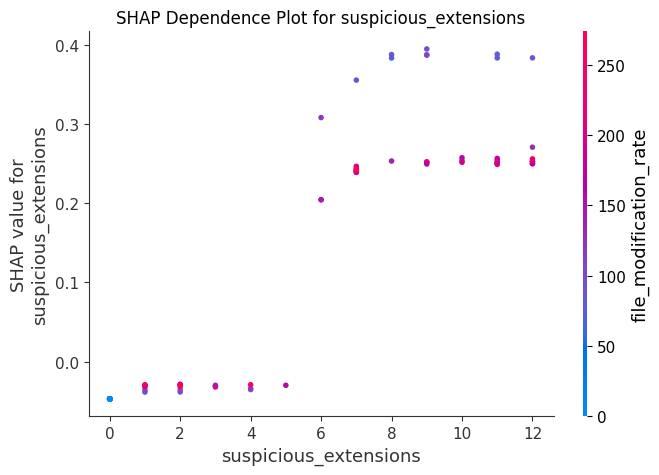

Plotting dependence for feature: process_cpu_mean


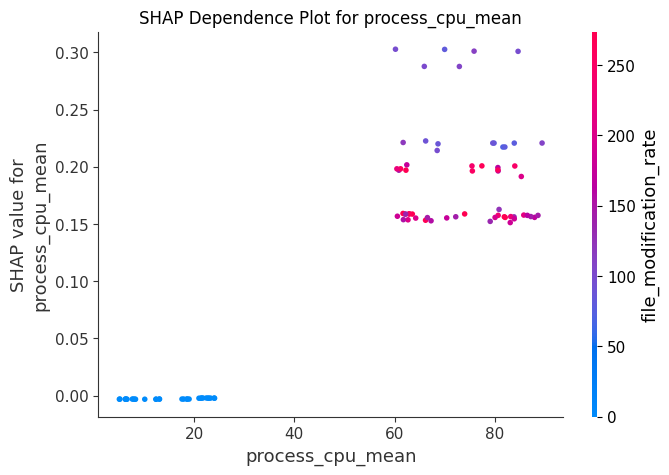

Plotting dependence for feature: process_cpu_max


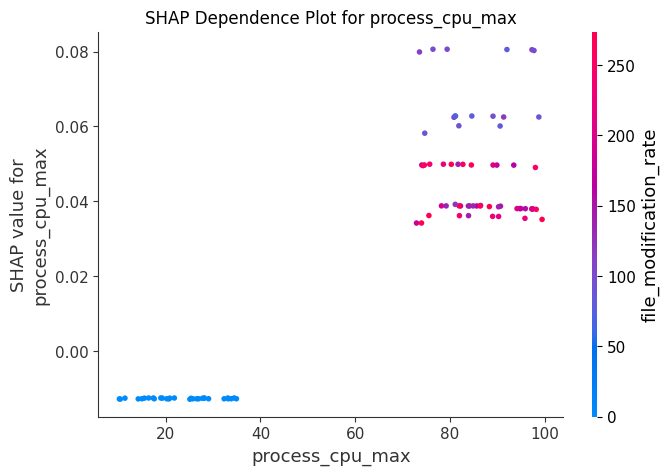

Plotting dependence for feature: process_memory_mean


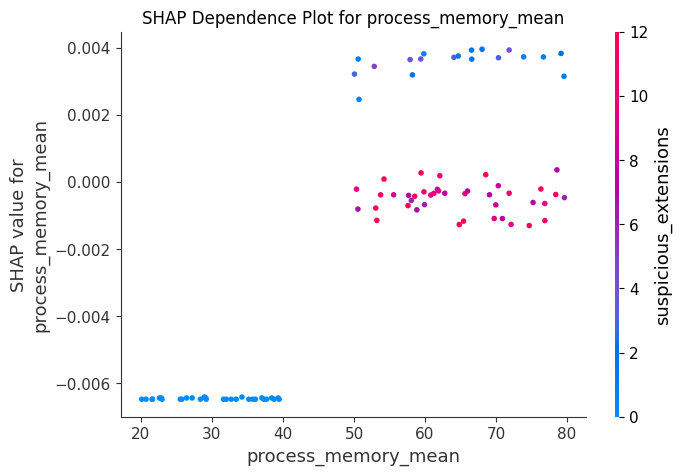

Plotting dependence for feature: process_memory_max


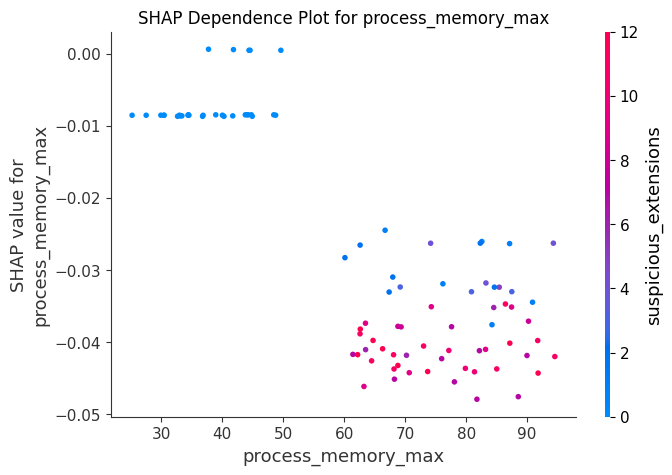

Plotting dependence for feature: active_processes


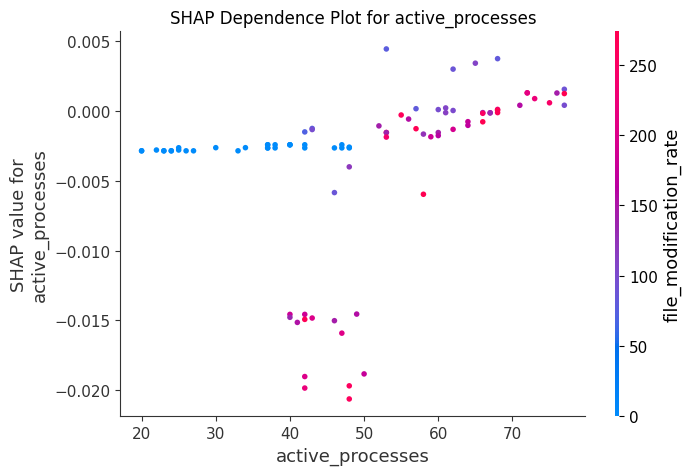

Plotting dependence for feature: network_connections


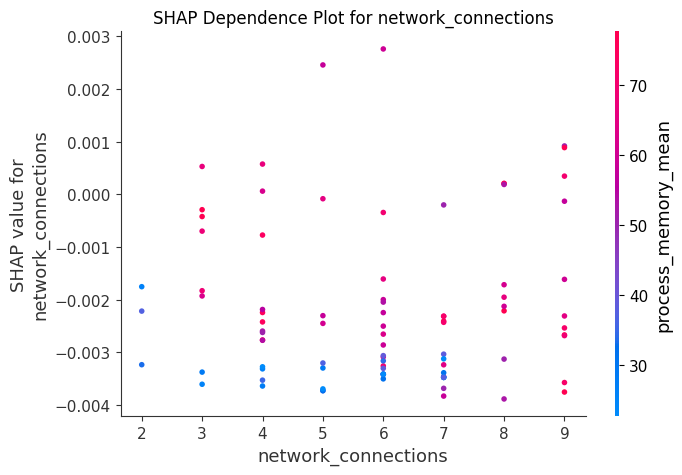

Plotting dependence for feature: file_creation_rate


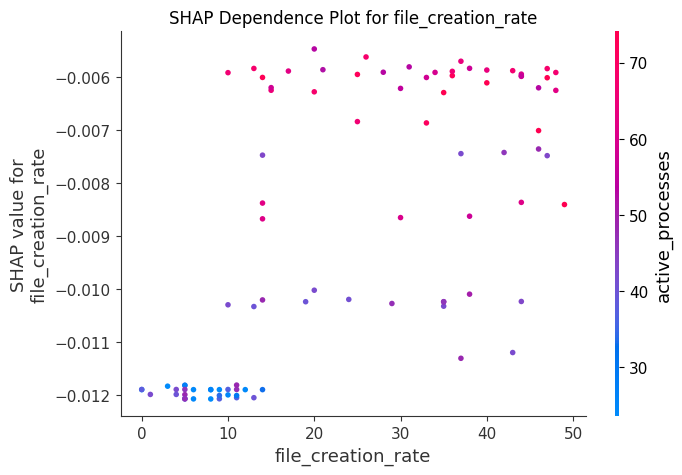

Plotting dependence for feature: file_deletion_rate


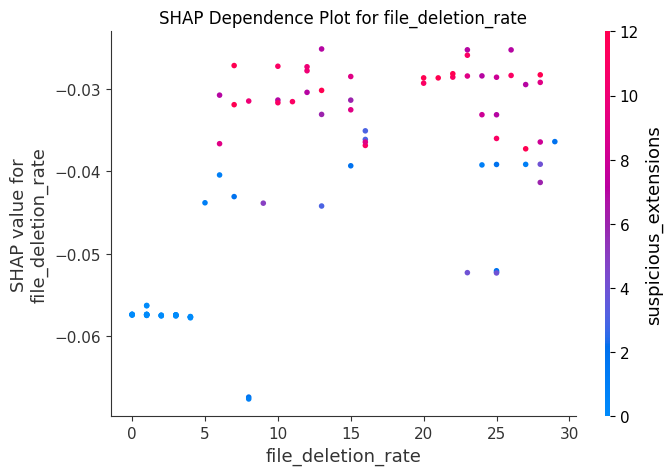

Plotting dependence for feature: file_modification_rate


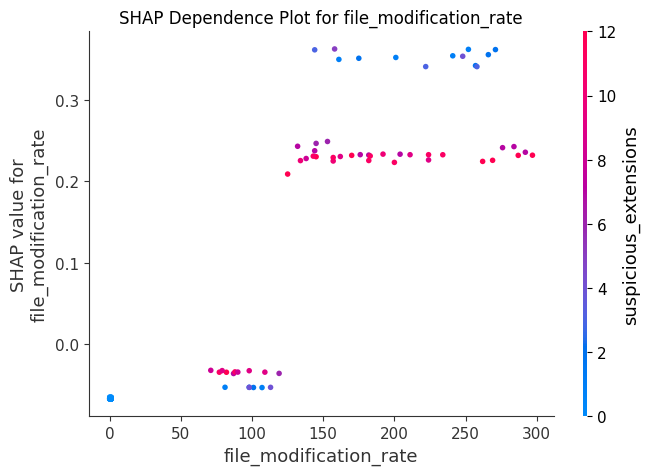

In [9]:
import matplotlib.pyplot as plt

print("\n--- Explainability Evaluation (SHAP) ---")
if X_test_scaled is not None and X_test is not None and model is not None:
    try:
        # Determine the appropriate SHAP explainer based on model type
        if hasattr(model, 'tree_ensemble') or "sklearn.ensemble" in str(type(model)) or "xgboost" in str(type(model)) or "lightgbm" in str(type(model)):
            explainer = shap.TreeExplainer(model)
        else:
            # For other models, use KernelExplainer. This can be computationally intensive.
            # We'll sample a smaller background dataset for performance.
            print("Using KernelExplainer, which can be slow. Sampling background data...")
            if X_test_scaled.shape[0] > 100:
                # Use a subset of the data as background for KernelExplainer
                background = shap.sample(X_test_scaled, 100)
            else:
                background = X_test_scaled
            explainer = shap.KernelExplainer(model.predict_proba if hasattr(model, 'predict_proba') else model.predict, background)

        shap_values = explainer.shap_values(X_test_scaled)

        # For binary classification, focus on SHAP values for the positive class (index 1)
        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_values = shap_values[1] 
        elif isinstance(shap_values, list) and len(shap_values) == 1:
            shap_values = shap_values[0] # For single output models like some regressors
        
        # Ensure feature names are available for plotting
        feature_names = X_test.columns.tolist() if isinstance(X_test, pd.DataFrame) else [f'feature_{i}' for i in range(X_test.shape[1])]

        # Visualize the first prediction's explanation
        print("\nSHAP explanation for the first test instance:")
        shap.initjs() 
        if isinstance(explainer, shap.TreeExplainer):
            shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], feature_names=feature_names)
        else:
            # For KernelExplainer, expected_value might be a single float or an array depending on output
            expected_value_for_plot = explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) and len(explainer.expected_value) > 1 else explainer.expected_value
            shap.force_plot(expected_value_for_plot, shap_values[0,:], X_test.iloc[0,:], feature_names=feature_names)
        plt.show()

        # Summary plot of feature importance
        print("\nSummary plot of feature importance:")
        # Pass X_test (DataFrame) directly to allow for colormapping
        shap.summary_plot(shap_values, X_test, feature_names=feature_names)
        plt.show()

        # Dependence plots for all features
        if X_test.shape[1] > 0:
            print("\nGenerating Dependence plots for all features...")
            for feature in feature_names:
                print(f"Plotting dependence for feature: {feature}")
                shap.dependence_plot(feature, shap_values, X_test, interaction_index="auto", show=False)
                plt.title(f"SHAP Dependence Plot for {feature}")
                plt.show()
        else:
            print("No features available for dependence plots.")

    except Exception as e:
        print(f"An error occurred during SHAP explanation generation: {e}")
        print("Please ensure SHAP and your model are compatible. You might need to adjust the explainer type or parameters.")
else:
    print("Cannot perform explainability evaluation: Model, test data, or scaled test data is not available.")




Summary plot (bar) of mean absolute SHAP values:


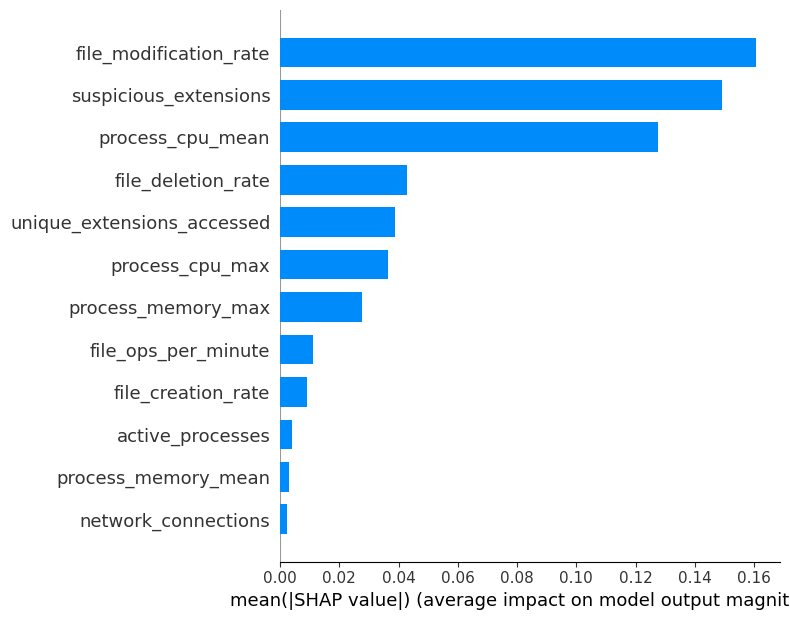

In [10]:
import matplotlib.pyplot as plt
import shap

# Generate a bar plot summary
print("\nSummary plot (bar) of mean absolute SHAP values:")
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)
plt.show()

In [11]:
# Calculate and display the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap_value': mean_abs_shap_values
})
feature_importance_df = feature_importance_df.sort_values(by='mean_abs_shap_value', ascending=False)

print("\nMean absolute SHAP values for each feature:")
print(feature_importance_df)


Mean absolute SHAP values for each feature:
                       feature  mean_abs_shap_value
11      file_modification_rate             0.160749
2        suspicious_extensions             0.149252
3             process_cpu_mean             0.127646
10          file_deletion_rate             0.042704
1   unique_extensions_accessed             0.038839
4              process_cpu_max             0.036577
6           process_memory_max             0.027564
0          file_ops_per_minute             0.011250
9           file_creation_rate             0.008930
7             active_processes             0.004171
5          process_memory_mean             0.003172
8          network_connections             0.002416


In [12]:
# Display the top 10 contributing features
print("\nTop 10 contributing features to the model's prediction:")
print(feature_importance_df.head(10))


Top 10 contributing features to the model's prediction:
                       feature  mean_abs_shap_value
11      file_modification_rate             0.160749
2        suspicious_extensions             0.149252
3             process_cpu_mean             0.127646
10          file_deletion_rate             0.042704
1   unique_extensions_accessed             0.038839
4              process_cpu_max             0.036577
6           process_memory_max             0.027564
0          file_ops_per_minute             0.011250
9           file_creation_rate             0.008930
7             active_processes             0.004171
